# Example notebook for Multitask Neural Decoding code

---

### Introduction
This is an example notebook to show the framework to train and evaluate a model using the multitask neural decoding codebase. After the relevant packages are installed, the entire notebook is self-contained and should run entirely in the Jupyter Notebook!

### Project Goal

GOAL: Find a good mapping from input data to output data.

We want to develop a more interpretable and better performing method of neural decoding across different types of input data. The input data could include data from multiple different distributions, but a robust model should still be able to perform good decoding. The model is trained to perform clustering of the data into separate modes and uses the learned clustering to compute a weighted average over the different decoders in the model. The learned clustering information can be extracted for downstream analysis, which is explained in the "Evaluate trained model" section.

### Code
The code loads a custom dataset, trains a model to decode the output from input, and evaluates the trained model (more details later in the notebook).

Feel free to reach out to Andrew at andrewshen2025@u.northwestern.edu if you have any questions!


---

### Define paths to custom dataset 

You need to set the paths to the training and validation datasets in numpy format for the custom dataset. An example dataset is provided in "example_custom_dataset".

A quick clarification on variable names for training!
- input: the numerical values for a sample of input data 
- output: the numerical values for a sample of output data 

In [15]:
# SET THESE TO YOUR OWN PATHS FOR TRAINING DATASETS
input_train_path = "example_custom_dataset/input_train.npy"
output_train_path = "example_custom_dataset/output_train.npy"
# SET THESE TO YOUR OWN PATHS FOR VALIATION DATASETS
input_val_path = "example_custom_dataset/input_val.npy"
output_val_path = "example_custom_dataset/output_val.npy"

### Import packages

See the provided "requirements.txt" file for specific versions of the installed packages.

In [16]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.utilities import disable_possible_user_warnings
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score

###  Define custom dataset

In [17]:
class Dataset_Custom(pl.LightningDataModule):
    """
    Format of each sample in custom dataset: (input data, output data, label)

    Ex: For example custom dataset with input_dim=95 and output_dim=16
    (tensor([2.5611, 1.2971, 0.7090, 0.9327, 4.2201, 1.1360, 0.5110, 2.6609, 0.2422,
        0.0000, 0.7357, 2.1263, 0.9272, 2.0391, 2.4139, 1.3121, 2.7412, 0.8519,
        1.6456, 0.6171, 0.5245, 3.2119, 0.8513, 1.5261, 1.0906, 2.1694, 1.5558,
        2.1784, 1.7563, 3.8693, 1.7945, 2.6794, 4.2998, 2.9552, 1.7912, 1.9162,
        1.5148, 0.9489, 4.0711, 1.4851, 0.6682, 1.8905, 3.1402, 1.5024, 0.7209,
        0.5516, 1.1371, 2.6699, 2.4621, 2.3039, 1.5001, 0.8161, 1.2647, 0.8475,
        1.0783, 0.6021, 1.1103, 1.4497, 1.1852, 1.2961, 0.6654, 0.2433, 2.4981,
        1.3982, 1.5237, 1.4347, 1.7953, 2.0746, 1.5488, 1.0058, 4.2330, 2.4696,
        1.5771, 1.4689, 2.3716, 1.1870, 2.2239, 4.0568, 1.7596, 2.2208, 2.9787,
        2.7364, 1.5793, 0.3041, 2.0491, 2.8336, 0.2575, 1.3711, 2.1987, 0.7316,
        2.1494, 0.5839, 2.0408, 4.3838, 3.2163]), tensor([36.4070, 38.6035, 57.3357,  9.2077, 10.2813, 20.2003,  9.8427, 17.1796,
        53.2993, 16.0262, 19.3980, 18.1566, 30.4801, 30.9933, 43.3886, 33.1731]))
    """
    
    def __init__(self, input_train_path,
                       output_train_path,
                       input_val_path,
                       output_val_path, num_modes, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.num_modes = num_modes
        self.train_dataset = None
        self.val_dataset = None
        self.input_dim = None
        self.output_dim = None

        # Read in data
        input_train = torch.Tensor(np.load(input_train_path))
        output_train = torch.Tensor(np.load(output_train_path))
        input_val = torch.Tensor(np.load(input_val_path))
        output_val = torch.Tensor(np.load(output_val_path))

        # Account for inputs with 1-dimensional features
        if len(input_train.shape) == 1:
            input_train = input_train.unsqueeze(1)
            input_val = input_val.unsqueeze(1)

        self.train_dataset = [(input_train[i], output_train[i]) for i in range(len(input_train))]
        self.val_dataset = [(input_val[i], output_val[i]) for i in range(len(input_val))]
        self.input_dim = input_train.size()[1]
        self.output_dim = output_train.size()[1]
            

    def __len__(self):
        """
        Returns number of samples in the training set.
        """
        
        return len(self.train_dataset) + len(self.val_dataset)


    def __getitem__(self, index):

        # Not used for the training
        return self.train_dataset[index]


    def collate_fn(self, batch):
        
        final_batch = {}
        X = []  # input
        Y1 = []  # output
        for sample in batch:
            X.append(sample[0])
            Y1.append(sample[1])
        final_batch["input"] = torch.stack(X)
        final_batch["output"] = torch.stack(Y1).float()

        return final_batch


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, shuffle=True)


    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn)

### Define model

In [18]:
# Clustering model
class ClusterModel(nn.Module):
    """
    input_dim: N
    num_modes: d
    """

    def __init__(self, input_dim, num_modes):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(input_dim, 1) for i in range(num_modes)])
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        x_d = []
        for linear in self.linears:
            x_d.append(linear(x))
        x = torch.stack(x_d, 2)
        x = self.softmax(x) 
        return x
    
    
# Decoding model
class DecoderModel(nn.Module):
    """
    input_dim: N
    output_dim: M
    num_modes: d
    """
    
    def __init__(self, input_dim, output_dim, num_modes):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(input_dim, output_dim) for i in range(num_modes)])
    
    def forward(self, x):
        x_d = []
        for linear in self.linears:
            x_d.append(linear(x))
        x = torch.stack(x_d, 2)
        return x


class CombinedModel(nn.Module):
    """
    self.cm stores an instance of the cluster model
    self.dm stores an instance of the decoding model
    """

    def __init__(self, input_dim, output_dim, num_modes, ev):
        super(CombinedModel, self).__init__()
        self.cm = ClusterModel(input_dim, num_modes)
        self.dm = DecoderModel(input_dim, output_dim, num_modes)
        self.ev = ev

    def forward(self, x):
        x1 = self.cm(x)
        x2 = self.dm(x)
        output = torch.sum(x1 * x2, dim=-1)

        # Return softmax outputs if mode is "eval"
        if self.ev == True:
            return x1
        return output

### Define training module

In [19]:
class TrainingModule(LightningModule):

    def __init__(self, model, lr, weight_decay):
        super().__init__()
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay
        self.training_step_outputs = []
        self.training_step_preds = []
        self.val_step_outputs = []
        self.val_step_preds = []

    def forward(self, x):
        return self.model.forward(x)
    
    def training_step(self, batch):
        inputs = batch["input"]
        outputs = batch["output"]
        outputs_hat = self.model(inputs).squeeze()
        train_loss = F.mse_loss(outputs_hat, outputs)
        self.log("train_loss", train_loss, on_step=True)
        self.training_step_outputs += outputs.tolist()
        self.training_step_preds += outputs_hat.tolist()
        return train_loss

    def validation_step(self, batch):
        inputs = batch["input"]
        outputs = batch["output"]
        outputs_hat = self.model(inputs).squeeze()
        val_loss = F.mse_loss(outputs_hat, outputs)
        self.log("val_loss", val_loss, on_epoch=True)
        self.val_step_outputs += outputs.tolist()
        self.val_step_preds += outputs_hat.tolist()
        return val_loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer
    
class Callback(pl.Callback):
    
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        self.epoch_number = 0
        self.train_losses = []
        self.train_r2s = []
        self.val_losses = []
        self.val_r2s = []


    def on_train_epoch_end(self, trainer, pl_module):
        
        # Calculate loss over the epoch
        outputs = torch.Tensor(pl_module.training_step_outputs)
        outputs_hat = torch.Tensor(pl_module.training_step_preds)
        train_loss_epoch = F.mse_loss(outputs_hat, outputs)
        self.train_losses.append(train_loss_epoch.item())

        # Calculate R^2 metric
        train_r2 = r2_score(outputs, outputs_hat)
        pl_module.log("train_r2", train_r2)
        self.train_r2s.append(train_r2)

        # Reset stored outputs and preds for current epoch
        pl_module.training_step_outputs = []
        pl_module.training_step_preds = []
        self.epoch_number += 1
    

    def on_validation_epoch_end(self, trainer, pl_module):
        
        # Calculate loss over the epoch
        outputs = torch.Tensor(pl_module.val_step_outputs)
        outputs_hat = torch.Tensor(pl_module.val_step_preds)
        val_loss_epoch = F.mse_loss(outputs_hat, outputs)
        self.val_losses.append(val_loss_epoch.item())

        # Calculate R^2 metric
        val_r2 = r2_score(outputs, outputs_hat)
        pl_module.log("val_r2", val_r2)
        self.val_r2s.append(val_r2)

        # Reset stored outputs and preds for current epoch
        pl_module.val_step_outputs = []
        pl_module.val_step_preds = []

### Load dataset and train the model

The trained model is saved in the path: "checkpoints/checkpoints.ckpt"

In [20]:
# Parameters for model and training
d = 3 # number of modes
b = 8 # batch size
epochs = 150 # number of epochs
lr = 0.0001 # learning rate
weight_decay = 0.01 # regularization parameter, see https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html

# Load in dataset
# Can change this section if custom data formatting is desired (ex: custom train/test splits funcationality, k-fold validation, etc.)
save_path = "checkpoints"
dataset = Dataset_Custom(input_train_path=input_train_path,
                            output_train_path=output_train_path,
                            input_val_path=input_val_path,
                            output_val_path=output_val_path,
                            num_modes=d,
                            batch_size=b)

# Define model
model = CombinedModel(input_dim=dataset.input_dim,
                      output_dim=dataset.output_dim,
                      num_modes=dataset.num_modes,
                      ev=False)
model = TrainingModule(model=model,
                      lr=lr,
                      weight_decay=weight_decay)

# Define model checkpoints
filename = "checkpoints/checkpoints.ckpt"
if os.path.exists(filename):
    os.remove(filename)
save_callback = ModelCheckpoint(dirpath = save_path, filename="checkpoints")

# Define trainer
trainer = Trainer(max_epochs=epochs, callbacks=[Callback(dataset), save_callback], enable_progress_bar=False, logger=False)

# Fit the model
disable_possible_user_warnings()
trainer.fit(model, train_dataloaders=dataset.train_dataloader(), val_dataloaders=dataset.val_dataloader())


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params
----------------------------------------
0 | model | CombinedModel | 4.9 K 
----------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.020     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=150` reached.


### Display model logs

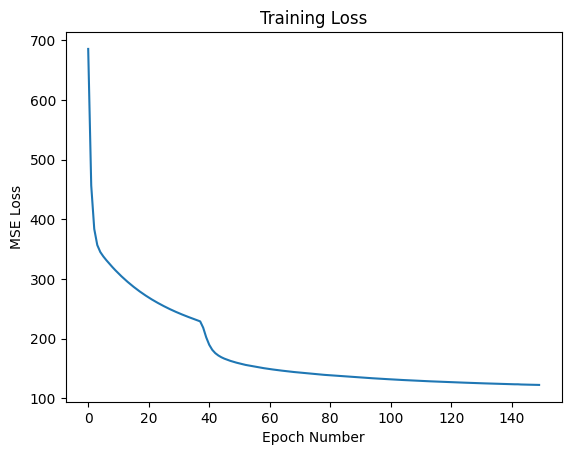

In [21]:
# Plot training losses
train_losses = trainer.callbacks[0].train_losses
plt.title("Training Loss")
plt.xlabel("Epoch Number")
plt.ylabel("MSE Loss")
plt.plot(range(len(train_losses)), train_losses)
plt.show()


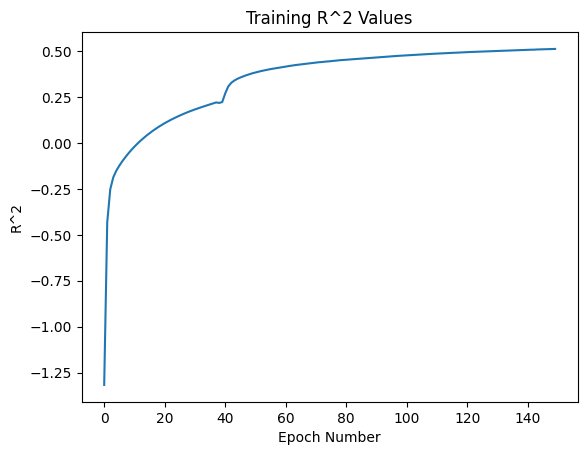

Final Train R^2 Value: 0.512509288217843


In [22]:
# Plot training R^2 values
train_r2s = trainer.callbacks[0].train_r2s
plt.title("Training R^2 Values")
plt.xlabel("Epoch Number")
plt.ylabel("R^2")
plt.plot(range(len(train_r2s)), train_r2s)
plt.show()
print("Final Train R^2 Value: %s" % train_r2s[-1])

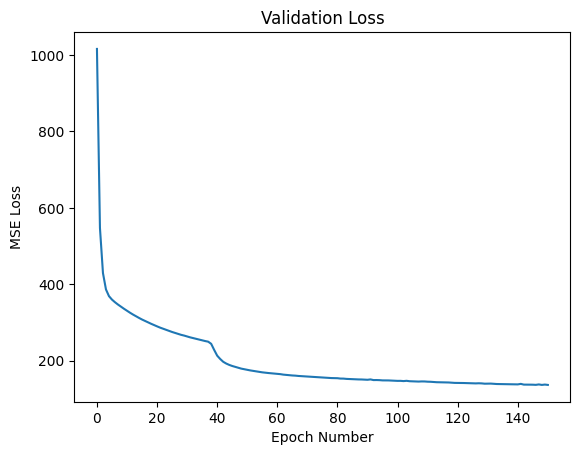

In [23]:
# Plot validation losses
val_losses = trainer.callbacks[0].val_losses
plt.title("Validation Loss")
plt.xlabel("Epoch Number")
plt.ylabel("MSE Loss")
plt.plot(range(len(val_losses)), val_losses)
plt.show()

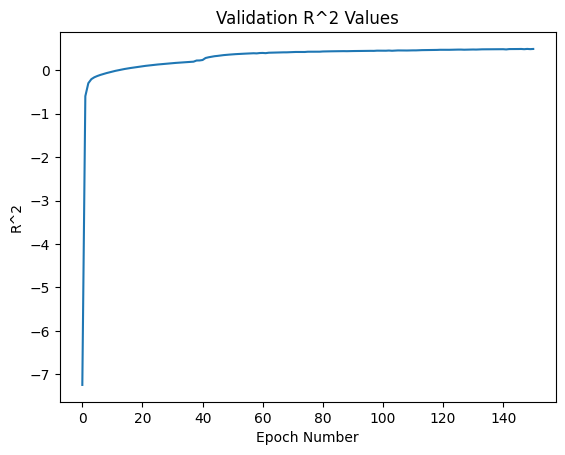

Final Validation R^2 Value: 0.490818146231177


In [24]:
# Plot validation R^2 values
val_r2s = trainer.callbacks[0].val_r2s
plt.title("Validation R^2 Values")
plt.xlabel("Epoch Number")
plt.ylabel("R^2")
plt.plot(range(len(val_r2s)), val_r2s)
plt.show()
print("Final Validation R^2 Value: %s" % val_r2s[-1])

### Evaluate trained model

To view the learned cluster probabilities for each mode, the input training data is fed through the model again to generate the learned clusters and stored in the variable "cluster_probs".

Note: The below code generates the cluster probabilities and final predictions for the validation set, but can be easily changed to examine results for the training set by changing the variable "dataset_type" from "val" to "train".

Relevant Variables
1. cm_weights: model weights for the Cluster model
2. dm_weights: model weights for the Decoder model
3. cluster_probs: learned cluster probabilities for each mode, has shape of (num_samples, num_modes)
4. train_outputs: ground truth values for output data, has shape of (num_samples, output_dim)
5. final_preds: final predictions from the model, has shape of (num_samples, output_dim)

*Sanity check: "final_preds" values should be similar to "train_outputs"


In [25]:
# Access dataset of interest
# dataset_type = "train"
dataset_type = "validation"
if dataset_type == "train":
    curr_dataset = dataset.train_dataset
elif dataset_type == "validation":
    curr_dataset = dataset.val_dataset

# Load trained model
model_path = filename
model = CombinedModel(input_dim=dataset.input_dim,
                      output_dim=dataset.output_dim,
                      num_modes=dataset.num_modes, 
                      ev=True)
checkpoint = torch.load(model_path)
state_dict = checkpoint["state_dict"]
model = TrainingModule(model=model,
                       lr=lr,
                       weight_decay=weight_decay)
model.load_state_dict(state_dict)

# Extract learned cluster model weights
cm_weights = model.model.cm.parameters()

# Extract learned decoder model weights
dm_weights = model.model.dm.parameters()

# Calculate learned cluster probabilities
"""
Output learned clusters will be of shape (num_samples, num_modes)
Ex: [0.0000, 0.0017, 0.9983] for num_modes=3 means the model learned that using 99.83% of mode 3 resulted in best performance
"""
cluster_probs = []
for sample in curr_dataset:
    x = sample[0].unsqueeze(0)
    curr_probs = model.forward(x)
    cluster_probs.append(curr_probs.squeeze())
cluster_probs = torch.stack(cluster_probs).detach()
torch.set_printoptions(sci_mode=False)
print("Learned %s cluster probabilities:\n%s" % (dataset_type, cluster_probs))

# Calculate final predictions
"""
Output predictions will be of shape (num_samples, output_dim)
"""
model.model.ev = False
final_preds = []
for sample in curr_dataset:
    x = sample[0].unsqueeze(0)
    pred = model.forward(x)
    final_preds.append(pred.squeeze())
final_preds = torch.stack(final_preds).detach()
print("\nFinal %s predictions:\n%s" % (dataset_type, final_preds))

# Extract ground truth validation labels
curr_dataset_outputs = torch.stack([sample[1] for sample in curr_dataset])
print("\nOutput %s labels:\n%s" % (dataset_type, curr_dataset_outputs))

Learned validation cluster probabilities:
tensor([[0.9576, 0.0295, 0.0129],
        [0.9397, 0.0475, 0.0128],
        [0.9423, 0.0499, 0.0078],
        ...,
        [0.9699, 0.0047, 0.0254],
        [0.9587, 0.0054, 0.0359],
        [0.9539, 0.0065, 0.0395]])

Final validation predictions:
tensor([[17.8246, 26.0660, 34.2081,  ..., 12.2937, 21.2492, 18.5404],
        [18.6053, 26.7015, 35.3315,  ..., 12.9283, 21.6689, 19.7942],
        [19.6025, 27.5090, 36.1389,  ..., 13.8059, 21.8716, 21.1572],
        ...,
        [ 9.6686, 13.1041, 23.8985,  ...,  9.8521, 14.2921, 16.2041],
        [11.1872, 15.6904, 26.1042,  ..., 10.6316, 16.4386, 17.7737],
        [12.3538, 17.6766, 27.6738,  ..., 10.9108, 17.4795, 18.4253]])

Output validation labels:
tensor([[ 9.2750, 18.3844, 28.8717,  ...,  4.7481,  5.0986,  6.0983],
        [ 9.3761, 19.0393, 33.2921,  ...,  5.2788,  5.0864,  6.6207],
        [ 8.5637, 24.0002, 43.1008,  ...,  5.4384,  5.1283,  6.8718],
        ...,
        [ 4.5639,  3.0898